## Importing Modules and Packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

import seaborn as sns
import matplotlib.pyplot as plt
import shap
from tqdm import tqdm,tqdm_notebook
import re
from nltk.stem import WordNetLemmatizer, SnowballStemmer,PorterStemmer
from nltk.stem.porter import *
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# ML Libs...
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

In [2]:
#ref - https://stackoverflow.com/questions/14463277/how-to-disable-python-warnings

# Basic Libs..
import warnings
warnings.filterwarnings("ignore")
import math
import pandas as pd
import numpy as np
import scipy
import scipy.sparse
from tqdm import tqdm,tqdm_notebook
import pickle
import os
print('CWD is ',os.getcwd())

# Vis Libs..
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Text Libs..
import re
from gensim import corpora, models
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer,PorterStemmer
from nltk.stem.porter import *
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# ML Libs...
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

# DL Libs..

CWD is  /home/ec2-user/IS434


In [3]:
df_train = pd.read_csv('train.tsv', '\t')
df_train = df_train.sample(n = 500_000)
df_train_split ,df_test_split = train_test_split(df_train,test_size = 0.25)

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500000 entries, 624646 to 1399116
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   train_id           500000 non-null  int64  
 1   name               500000 non-null  object 
 2   item_condition_id  500000 non-null  int64  
 3   category_name      497873 non-null  object 
 4   brand_name         286722 non-null  object 
 5   price              500000 non-null  float64
 6   shipping           500000 non-null  int64  
 7   item_description   499999 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 34.3+ MB


## Fill Missing Data

In [5]:
def fill_missing_data(data):
    data.brand_name.fillna(value = "Missing", inplace = True)
    data.category_name.fillna(value = "Missing", inplace = True)

fill_missing_data(df_train_split)
fill_missing_data(df_test_split)

## Remove outliers in Price Column

In [6]:
df_train_split[df_train_split["price"] < 3].count()

train_id             200
name                 200
item_condition_id    200
category_name        200
brand_name           200
price                200
shipping             200
item_description     200
dtype: int64

In [7]:
df_train_split[df_train_split["price"] > 2000].count()

train_id             2
name                 2
item_condition_id    2
category_name        2
brand_name           2
price                2
shipping             2
item_description     2
dtype: int64

In [8]:
df_train_split = df_train_split[(df_train_split.price >= 3)]
df_test_split = df_test_split[(df_test_split.price >= 3)]

In [9]:
df_train_split['log_price'] = np.log1p(df_train_split['price'])
df_test_split['log_price'] = np.log1p(df_test_split['price'])

## Item Description Processing

In [10]:
# function to decontract phrases
#https://stackoverflow.com/questions/43018030/replace-apostrophe-short-words-in-python
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def text_process(text):
    stop_words = stopwords.words('english')
    processed = []
    desc_length_tokenized = []
    for sentence in tqdm_notebook(text):
        sentence_decontracted = decontracted(sentence)
        sentence_decontracted = sentence_decontracted.replace('\\"', ' ')
        sentence_decontracted = sentence_decontracted.replace('\\`', ' ')
        sentence_decontracted = re.sub(r"[^0-9a-zA-Z]+", ' ', sentence_decontracted)
        text_tokens = word_tokenize(sentence_decontracted)
        desc_length_tokenized.append(len(text_tokens))
        joined_words = " ".join(word for word in text_tokens if word not in stop_words)
        processed.append(joined_words)
    return processed, desc_length_tokenized

In [11]:
df_train_split['item_description'] = df_train_split['item_description'].replace([np.nan],"No Description")
df_test_split['item_description'] = df_test_split['item_description'].replace([np.nan],"No Description")

In [12]:
df_train_split['item_desc_processed'], df_train_split['item_desc_length_tokenized'] = text_process(df_train_split['item_description'])
df_test_split['item_desc_processed'], df_test_split['item_desc_length_tokenized'] = text_process(df_test_split['item_description'])

In [13]:
tfidf_vectorizer=TfidfVectorizer(ngram_range=(1,3), min_df = 10, max_features=5000, use_idf=True) 
tfidf_vectorizer_vectors_train = tfidf_vectorizer.fit_transform(df_train_split['item_desc_processed'])
tfidf_vectorizer_vectors_test =tfidf_vectorizer.transform(df_test_split['item_desc_processed'])


X_train = tfidf_vectorizer_vectors_train
X_test = tfidf_vectorizer_vectors_test

y_train = df_train_split['log_price']
y_test = df_test_split['log_price']

In [14]:
print(tfidf_vectorizer_vectors_train.shape)

(374800, 5000)


## LightGBM with Tuning

In [15]:
from lightgbm import LGBMRegressor
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import r2_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [16]:
lgbm_tuned_params ={
    'learning_rate': 0.1,
    'n_estimators': 400,
    'num_leaves': 140,
    'max_depth' : 80,
    'boosting_type' : 'gbdt',
    'subsample': 0.9, 
    'colsample_bytree': 0.8, 
    'min_child_samples': 20, 
    'objective': 'regression'
             }

lgbm_tune_model = LGBMRegressor(**lgbm_tuned_params)
lgbm_tune_model.fit(X_train, y_train, early_stopping_rounds=None,verbose=True)

lgbm_pred_train_tuned = lgbm_tune_model.predict(X_train)
lgbm_pred_test_tuned  = lgbm_tune_model.predict(X_test)

In [17]:
# print('Train Mean Absolute Error:', metrics.mean_absolute_error(y_train, lgbm_pred_train_tuned))
# print('Train Mean Squared Error:', metrics.mean_squared_error(y_train, lgbm_pred_train_tuned))
# print('Train Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_train, lgbm_pred_train_tuned)))
# print('Train R^2:',r2_score(y_train, lgbm_pred_train_tuned))
# print("------------------------------")
# print('Test Mean Absolute Error:', metrics.mean_absolute_error(y_test, lgbm_pred_test_tuned))
# print('Test Mean Squared Error:', metrics.mean_squared_error(y_test, lgbm_pred_test_tuned))
# print('Test Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, lgbm_pred_test_tuned)))
# print('Test R^2:',r2_score(y_test, lgbm_pred_test_tuned))

## Ridge Regression

In [18]:
from sklearn.linear_model import Ridge

In [19]:
ridge_model_tuned = Ridge(alpha=6,solver="sag", fit_intercept=True)
ridge_model_tuned.fit(X_train, y_train) 
ridge_model_tuned_pred_train = ridge_model_tuned.predict(X_train)
ridge_model_tuned_pred_test = ridge_model_tuned.predict(X_test)

In [20]:
# print('Train Mean Squared Error:', metrics.mean_squared_error(y_train, ridge_model_tuned_pred_train))
# print('Train Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_train, ridge_model_tuned_pred_train)))
# print('Train R^2:',r2_score(y_train, ridge_model_tuned_pred_train))
# print("------------------------------")
# print('Test Mean Absolute Error:', metrics.mean_absolute_error(y_test, ridge_model_tuned_pred_test))
# print('Test Mean Squared Error:', metrics.mean_squared_error(y_test, ridge_model_tuned_pred_test))
# print('Test Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, ridge_model_tuned_pred_test)))
# print('Test R^2:',r2_score(y_test, ridge_model_tuned_pred_test))

## Ensemble

In [21]:
from sklearn.ensemble import VotingRegressor
voting_ensemble = VotingRegressor([('lightgbm', lgbm_tune_model), ('ridge', ridge_model_tuned)])
model = voting_ensemble.fit(X_train, y_train)

## SHAP

In [22]:
# importing SHAP
import shap

# sampling data from the training and test set to reduce time-taken
X_train_sample = shap.sample(X_train, 200)
X_test_sample = shap.sample(X_test, 40)

# creating the KernelExplainer using the logistic regression model and training sample
SHAP_explainer = shap.KernelExplainer(model.predict, X_train_sample)
# calculating the shap values of the test sample using the explainer 
shap_vals = SHAP_explainer.shap_values(X_test_sample)

# converting the test samples to a dataframe 
# this is necessary for non-tabular data in order for the visualisations 
# to include feature value
colour_test = pd.DataFrame(X_test_sample.todense())

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


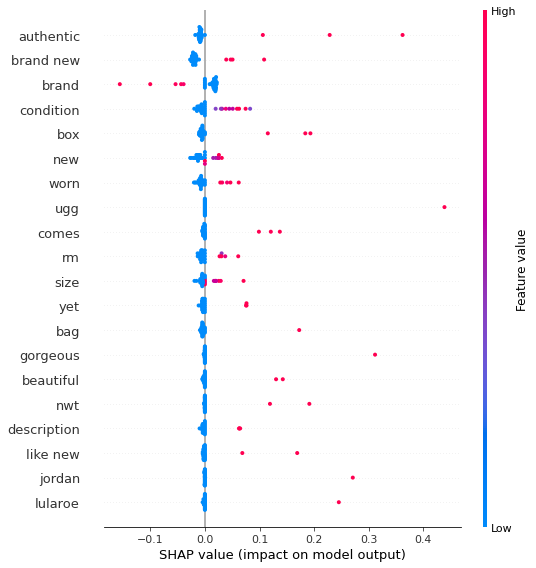

In [23]:
shap.summary_plot(shap_vals, colour_test, feature_names=tfidf_vectorizer.get_feature_names())